# Data Sourcing & Cleaning
<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Get-Data:-Fire-Incidents" data-toc-modified-id="Get-Data:-Fire-Incidents-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get Data: Fire Incidents</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Cleaning</a></span><ul class="toc-item"><li><span><a href="#Missing-&amp;-duplicated-values" data-toc-modified-id="Missing-&amp;-duplicated-values-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Missing &amp; duplicated values</a></span></li><li><span><a href="#Data-types" data-toc-modified-id="Data-types-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data types</a></span></li><li><span><a href="#Distribution-of-values-&amp;-outliers" data-toc-modified-id="Distribution-of-values-&amp;-outliers-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Distribution of values &amp; outliers</a></span><ul class="toc-item"><li><span><a href="#Dates" data-toc-modified-id="Dates-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Dates</a></span></li><li><span><a href="#Acres-burned" data-toc-modified-id="Acres-burned-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Acres burned</a></span></li><li><span><a href="#Coordinates" data-toc-modified-id="Coordinates-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Coordinates</a></span></li></ul></li></ul></li><li><span><a href="#Get-Data:-Weather" data-toc-modified-id="Get-Data:-Weather-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get Data: Weather</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data Cleaning</a></span></li></ul></div>

## Introduction
In this notebook, we'll be going through several steps to get our data and clean it.  

Data sourcing steps include:
* Web-scraping CalFire's website for fire incident data
* Making API requests through DarkSky for weather data on the date of each fire incident

The output of this notebook will be a clean pandas dataframe with both data sources.

## Import libraries

In [1]:
# data analysis & manipulation
import pandas as pd
import numpy as np
import geopandas

# web scraping
import requests
from bs4 import BeautifulSoup

# tools
import re
import pickle

# visualizations
import matplotlib.pyplot as plt
%matplotlib inline

print('Pandas version:', pd.__version__)

Pandas version: 1.0.3


## Get Data: Fire Incidents

We're going to be getting our fire incidents data for the past 7 years from <www.fire.ca.gov>. 

First, let's construct the urls we'll be pulling data from.

In [2]:
def construct_url_fire():
    '''Returns a list of fire incident urls.'''
    years = ['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013']
    domain = 'https://www.fire.ca.gov/incidents/'
    urls = [domain + y for y in years]
    return urls

urls = construct_url_fire()
print(urls)

['https://www.fire.ca.gov/incidents/2020', 'https://www.fire.ca.gov/incidents/2019', 'https://www.fire.ca.gov/incidents/2018', 'https://www.fire.ca.gov/incidents/2017', 'https://www.fire.ca.gov/incidents/2016', 'https://www.fire.ca.gov/incidents/2015', 'https://www.fire.ca.gov/incidents/2014', 'https://www.fire.ca.gov/incidents/2013']


Now that we have our urls, we'll make a request for each fire incidents page and make soup using the [Requests](https://2.python-requests.org/en/master/) and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) libraries, respectively.

Beautiful Soup transforms a complex HTML document into a complex tree of Python objects.

In [3]:
def make_soup(urls):
    '''Input urls and return a list of soup objects.'''
    soups = []
    for url in urls:
        # make request
        response = requests.get(url)
        print(response.status_code, url)
        # encode text
        page = response.text
        # make soup
        soup = BeautifulSoup(page, 'lxml')
        soups.append(soup)
    return soups

soups = make_soup(urls)

200 https://www.fire.ca.gov/incidents/2020
200 https://www.fire.ca.gov/incidents/2019
200 https://www.fire.ca.gov/incidents/2018
200 https://www.fire.ca.gov/incidents/2017
200 https://www.fire.ca.gov/incidents/2016
200 https://www.fire.ca.gov/incidents/2015
200 https://www.fire.ca.gov/incidents/2014
200 https://www.fire.ca.gov/incidents/2013


The status code '200' indicates a successful request and it looks like we were able to successfully get all the data.

Now that we have our BeautifulSoup objects in a list, we need to extract the fire incidents data which is in a javascript variable named *'incidentListTableInitialData'* within the HTML object.

We'll be using a regular expression to find the aforementioned fire incidents data and append it to a list.

In [4]:
def get_json():
    '''Input soups and return a list of json-like objects.'''
    json_list = []
    for ix, soup in enumerate(soups):
        # regex to find the incidents table
        regex = '(?<=incidentListTableInitialData = \[)\{.+}(?=];)'
        # return match within soup object  
        json_list.append(re.findall(regex, soup.text)[0])
    return json_list

json_list = get_json()
print('Length of list:', len(json_list))

Length of list: 8


Let's create our first dataframe.

In [5]:
def create_dataframe(json_list):
    '''Convert list of JSON strings to a pandas dataframe.'''
    df_list = []
    for item in json_list:
        # create df from each json object (one per year)
        json_df = pd.read_json(item, lines=True)
        df_list.append(json_df)
    # concatenate all json dataframes
    df = pd.concat(df_list)
    return df

fire_df = create_dataframe(json_list)
print(fire_df.shape)

(1635, 40)


In [6]:
# pickle
fire_df.to_pickle('../data/01_fire_df.pkl')

## Data cleaning

With our first dataframe created, we can explore it a bit to see what needs cleaning. 

We'll set a shortened `UniqueId` as the index.

In [7]:
def get_last_6_id():
    '''Return last 6 chars of unique id and set it as the index'''
    fire_df['UniqueId'] = fire_df['UniqueId'].apply(lambda x: x[-6:])
    fire_df.set_index('UniqueId', drop=True, inplace=True)
    fire_df.index.name = None
    
get_last_6_id()
fire_df.head()

,Name,Location,Latitude,Longitude,AcresBurned,FuelType,PercentContained,ControlStatement,ConditionStatement,Counties,...,StructuresEvacuated,PersonnelInvolved,CrewsInvolved,Injuries,Fatalities,Helicopters,Engines,Dozers,WaterTenders,AirTankers
5c3935,Bear Fire,"Bear Creek Road and Anderson Ford Road, Northw...",40.511092,-123.637841,15.0,NaN,100.0,NaN,NaN,[Humboldt],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116827,Antelope Fire,"Hwy 49 and Fillippini Road, Sierraville",39.692300,-120.329185,102.0,NaN,100.0,NaN,NaN,[Sierra],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ef6d63,Beegum Fire,"Off of Highway 36 West and Tedoc Rd, West of R...",40.335833,-122.847222,75.0,NaN,100.0,NaN,NaN,[Tehama],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7c5912,Wood Fire,"Off Horselake Road and Woodranch Road, East of...",40.621550,-120.493920,57.0,NaN,100.0,NaN,NaN,[Lassen],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74f110,Baseball Fire,"Off Atchison Creek, East of Covelo",39.756389,-122.941111,211.0,NaN,100.0,NaN,NaN,"[Glenn, Mendocino]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing & duplicated values

In [8]:
fire_df.isna().sum().sort_values(ascending=False)

StructuresEvacuated     1635
FuelType                1623
Fatalities              1620
StructuresThreatened    1611
AirTankers              1606
StructuresDamaged       1573
Helicopters             1551
Injuries                1524
Dozers                  1513
WaterTenders            1490
StructuresDestroyed     1474
CrewsInvolved           1467
Engines                 1445
PersonnelInvolved       1435
ControlStatement         260
ConditionStatement       208
SearchKeywords           205
Extinguished              64
SearchDescription         19
PercentContained           5
AcresBurned                5
Longitude                  0
Latitude                   0
Counties                   0
CountyIds                  0
Location                   0
Active                     0
AdminUnit                  0
Updated                    0
Started                    0
ArchiveYear                0
Public                     0
Featured                   0
CalFireIncident            0
MajorIncident 

We have several columns with many missing values.  

Let's drop any columns that have less than 1571 non-null values. Why 1571? 

That's the count of non-null values for 'Extinguished' date which could be an important feature. There are 1634 total rows – most of the other features have significantly more null values.

In [9]:
def drop_missing():
    '''Drop columns and rows with defined missing values and return dataframe.'''
    # setting threshold to value of non-null 'Extinguished'
    thresh = 1571
    # drop columns with less than 1571 non-null values
    fire_df_1 = fire_df.dropna(axis=1, thresh=thresh)
    # drop all rows with any missing values
    clean_fire_df = fire_df_1.dropna()
    return clean_fire_df

print('Before', fire_df.shape)
fire_df = drop_missing()
print('After', fire_df.shape)

Before (1635, 39)
After (1558, 22)


We dropped 17 columns and 77 rows. Let's check for duplicated rows.

In [10]:
# check for duplicated rows
# note: we need to drop 'Counties' as it's a list (unhashable)
fire_df.drop(columns='Counties').duplicated().sum()

0

Let's drop columns that we won't be needing to reduce the scope. We might drop more columns later.

In [11]:
cols_drop = ['Location', 'PercentContained', 'CountyIds', 'SearchDescription', 'ArchiveYear', 
             'Public', 'Active', 'Featured', 'MajorIncident', 'Final', 'Status', 'CanonicalUrl'
            ]
def drop_columns(df, col_list):
    '''Input list of columns to drop and return a dataframe.'''
    df = df.drop(columns=cols_drop)
    return df

fire_df = drop_columns(fire_df, cols_drop)
print(fire_df.shape)

(1558, 10)


### Data types

Let's convert our 11 features to the best data types.

In [12]:
fire_df = fire_df.convert_dtypes()
fire_df.dtypes

Name                string
Latitude           float64
Longitude          float64
AcresBurned          Int64
Counties            object
AdminUnit           string
Updated             string
Started             string
Extinguished        string
CalFireIncident    boolean
dtype: object

The `convert_dtypes` function only converted some objects to strings.  

We'll need to convert:
* string dates to datetime objects
* 'AdminUnit' to categorical

In [13]:
# save original 'Updated' column for later use
fire_df['StartedOriginal'] = fire_df.loc[:, ['Started']]
# convert to datetimes
fire_df.loc[:, ['Updated', 'Started', 'Extinguished']] = fire_df.loc[:, ['Updated', 'Started', 'Extinguished']].apply(pd.to_datetime)
# convert to categories
fire_df['AdminUnit'] = fire_df['AdminUnit'].astype('category')
fire_df.dtypes

Name                            string
Latitude                       float64
Longitude                      float64
AcresBurned                      Int64
Counties                        object
AdminUnit                     category
Updated            datetime64[ns, UTC]
Started            datetime64[ns, UTC]
Extinguished       datetime64[ns, UTC]
CalFireIncident                boolean
StartedOriginal                 object
dtype: object

### Distribution of values & outliers

In [14]:
fire_df.drop(columns='Counties').describe(include='all')

,Name,Latitude,Longitude,AcresBurned,AdminUnit,Updated,Started,Extinguished,CalFireIncident,StartedOriginal
count,1558,1558.000000,1558.000000,1558.000000,1558,1558,1558,1558,1558,1558
unique,1156,NaN,NaN,NaN,482,1074,1546,1038,2,1546
top,Creek Fire,NaN,NaN,NaN,CAL FIRE Sonoma-Lake-Napa Unit,2018-01-09 13:46:00+00:00,2015-07-29 16:30:00+00:00,2018-01-09 13:46:00+00:00,True,2015-07-30T16:00:00Z
freq,14,NaN,NaN,NaN,80,7,2,7,1192,2
first,NaN,NaN,NaN,NaN,NaN,1969-12-31 16:00:00+00:00,1969-12-31 16:00:00+00:00,1969-12-31 16:00:00+00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2020-03-09 11:22:07.247000+00:00,2020-03-02 14:08:05+00:00,2020-03-05 07:26:00+00:00,NaN,NaN
mean,NaN,37.128494,-107.222935,3558.467266,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,138.759998,38.098762,19685.343772,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,-120.258000,-124.196290,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,34.099758,-121.732243,35.000000,NaN,NaN,NaN,NaN,NaN,NaN


There are a few notable issues:
* There are dates from 1969
* `AcresBurned` is highly skewed
* There are some coordinates that seem to be outside of California
* There are several `AdminUnit` (high cardinality)

Let's take care of the first three. We'll handle `AdminUnit` in the feature engineering step.

#### Dates

In [15]:
fire_df.groupby(fire_df['Started'].dt.year)['Started'].count()

Started
1969      2
2013    159
2014    115
2015    157
2016    184
2017    435
2018    309
2019    192
2020      5
Name: Started, dtype: int64

In [16]:
print("Before:", fire_df.shape)
# keep fire incidents between 2013-2019
fire_df = fire_df.loc[(fire_df['Started']>='2013-01-01') &
            (fire_df['Started']<='2019-12-31') &
            (fire_df['Extinguished']>='2013-01-01') &
            (fire_df['Extinguished']<='2020-01-31')
           ]
print("After:", fire_df.shape)

Before: (1558, 11)
After: (1549, 11)


We removed fire incidents that were in 2020 and a few that had erroneous dates. 

#### Acres burned

Let's take a closer look at our target variable to see how skewed it is.

In [17]:
fire_df['AcresBurned'].sort_values(ascending=False)

faf950    410203
d40bee    281893
939e78    257314
7a6c9d    229651
87f217    191125
           ...  
b4aab8         0
0275af         0
0d9939         0
953195         0
423262         0
Name: AcresBurned, Length: 1549, dtype: Int64

In [18]:
print((fire_df['AcresBurned'].describe().astype('int')))
print((fire_df['AcresBurned'].median().astype('int')))

count      1549
mean       3578
std       19740
min           0
25%          35
50%          99
75%         415
max      410203
Name: AcresBurned, dtype: int64
99


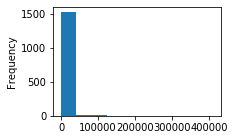

In [19]:
# distribution of acres burned
fire_df['AcresBurned'].plot(kind='hist', figsize=(3, 2))

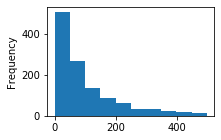

In [20]:
# reduce scope to less than 500 acres burned
fire_df.loc[fire_df['AcresBurned']<500, 'AcresBurned'].plot(kind='hist', figsize=(3, 2))

Well, this is going to make it tough to predict how many acres will burn given a fire.  
The standard deviation is ~20k acres with the mean being ~3,500 and the median being ~100.

In [21]:
# drop rows where no acres were burned
fire_df = fire_df.loc[~(fire_df['AcresBurned']==0)]

#### Coordinates

The min/max coordinates indicate that there are observations outside of California.  
Let's check it out.

In [22]:
# create geo dataframe from our dataframe (fire incidents)
gdf = geopandas.GeoDataFrame(fire_df, geometry=geopandas.points_from_xy(fire_df['Longitude'], fire_df['Latitude']))
# create geo dataframe with shape files (United States)
map_url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_1_states_provinces_shp.geojson'
us_map = geopandas.read_file(map_url)
# filter for California
california = us_map.loc[us_map['name']=='California']

In [23]:
# checks if each point is within the California polygon
gdf_california = gdf['geometry'].within(california['geometry'].unary_union)
gdf_california.value_counts()

True     1340
False     181
dtype: int64

There are 181 points that are outside of California.  
We'll be getting rid of these since we need accurate coordinates to make an API call to get weather data.

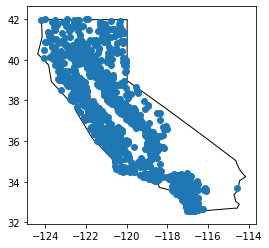

In [24]:
# define axis to California
ax = california.plot(color='white', edgecolor='black')
# plot points
gdf.loc[gdf_california==True, 'geometry'].plot(ax=ax)

The plot reveals that all of our points are within California.  
We can now convert our geopandas dataframe back to a dataframe.

In [25]:
# convert to pandas dataframe 
fire_df = pd.DataFrame(gdf.loc[gdf_california==True])

In [26]:
# pickle
fire_df.to_pickle('../data/01_fire_df.pkl')

## Get Data: Weather

We'll be getting our weather data from the [DarkSky API](https://darksky.net/dev).  
The Dark Sky API requires the request url to have the following format:  
>https://api.darksky.net/forecast/[key]/[latitude],[longitude],[time]

Let's construct the request url.

In [27]:
def construct_url_weather():
    '''Returns urls with parameters required by the DarkSky API as a pandas series'''
    # clean date by removing extra digits
    fire_df['StartedOriginal'] = fire_df.loc[:, 'StartedOriginal'].str.replace('\.\d+', '')
    # params
    api_key = '4f4ef1267ba7015a5e1b8aee6fb45ded'
    url_start = 'https://api.darksky.net/forecast/4f4ef1267ba7015a5e1b8aee6fb45ded/'
    url_end = '?exclude=currently,minutely,hourly,flags'
    lat = fire_df['Latitude'].astype(str)
    lon = fire_df['Longitude'].astype(str)
    dt = fire_df['StartedOriginal'].astype(str)
    # put it all together
    fire_df['RequestURL'] = url_start + lat + ',' + lon + ',' + dt + url_end

construct_url_weather()

The code below makes a call for each start date of a wildfire (1 row per wildfire) and appends the weather data to a dataframe as a row.  

In [28]:
def get_weather_data():
    '''Makes requests to the DarkSky API and returns weather data in a pandas dataframe'''
    weather_df = pd.DataFrame()
    for idx, url in fire_df.loc[:, 'RequestURL'].iteritems():
        response = requests.get(url)
        if response.status_code == 400: # bad request
            print(f'{idx}', response.status_code)
        else:
            # normalize weather json
            row = pd.json_normalize(response.json(), ['daily', 'data'])
            # set index
            row['UniqueId'] = idx
            row.set_index('UniqueId', drop=True, inplace=True)
            row.index.name = None
            # append row
            weather_df = weather_df.append(row)
    return weather_df

weather_df = get_weather_data()
print(weather_df.shape)

(1340, 40)


In [29]:
# pickle
weather_df.to_pickle('../data/01_weather_df.pkl')

## Data Cleaning

We need to avoid multi-collinearity as many of these features are highly similar.  
Let's remove some features.

In [30]:
weather_df.head()

,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,precipIntensityMaxTime,precipProbability,...,visibility,ozone,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
52378c,1546329600,Clear throughout the day.,clear-day,1546357200,1546390740,0.88,0.0006,0.0019,1.546351e+09,0.06,...,10.0,297.4,29.97,1546346220,52.46,1546379760,22.92,1546350960,51.98,1546379280
398fe2,1561446000,Clear throughout the day.,clear-day,1561466460,1561520220,0.77,0.0004,0.0014,1.561449e+09,0.01,...,10.0,342.5,62.02,1561466160,91.96,1561507200,62.51,1561466160,91.46,1561507200
030e7d,1556434800,Clear throughout the day.,clear-day,1556457180,1556505960,0.82,0.0009,0.0030,1.556504e+09,0.03,...,10.0,322.9,52.64,1556456880,83.37,1556487660,53.13,1556456880,82.87,1556487660
b5b503,1556607600,Clear throughout the day.,clear-day,1556629800,1556679720,0.88,0.0016,0.0066,1.556608e+09,0.15,...,10.0,368.4,52.82,1556631540,72.21,1556665440,53.31,1556631540,71.71,1556665440
abd7ac,1556607600,Clear throughout the day.,clear-day,1556629560,1556678520,0.88,0.0007,0.0023,1.556639e+09,0.05,...,10.0,346.4,50.37,1556628840,70.64,1556665800,50.86,1556628840,70.14,1556665800


In [31]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1340 entries, 52378c to 204744
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   time                         1340 non-null   int64  
 1   summary                      1195 non-null   object 
 2   icon                         1214 non-null   object 
 3   sunriseTime                  1340 non-null   int64  
 4   sunsetTime                   1340 non-null   int64  
 5   moonPhase                    1340 non-null   float64
 6   precipIntensity              1339 non-null   float64
 7   precipIntensityMax           1339 non-null   float64
 8   precipIntensityMaxTime       758 non-null    float64
 9   precipProbability            1337 non-null   float64
 10  precipType                   529 non-null    object 
 11  precipAccumulation           2 non-null      float64
 12  temperatureHigh              1340 non-null   float64
 13  temperatureHighT

In [32]:
columns_to_remove = [
    'apparentTemperatureHigh',
    'apparentTemperatureHighTime',
    'apparentTemperatureLow',
    'apparentTemperatureLowTime',
    'apparentTemperatureMax',
    'apparentTemperatureMaxTime',
    'apparentTemperatureMin',
    'apparentTemperatureMinTime', 
    'cloudCover',
    'icon', 
    'ozone',
    'precipIntensityMax',
    'precipIntensityMaxTime',
    'precipProbability',
    'precipType',
    'precipAccumulation',
    'pressure', 
    'summary',
    'sunriseTime',
    'temperatureHighTime', 
    'temperatureLowTime',
    'temperatureMax', 
    'temperatureMaxTime',
    'temperatureMin',
    'temperatureMinTime', 
    'time',
    'uvIndex', 
    'uvIndexTime', 
    'visibility',
    'windBearing', 
    'windGust',
    'windGustTime'
]
weather_df = weather_df.drop(columns_to_remove, axis=1)

In [33]:
weather_df.head()

,sunsetTime,moonPhase,precipIntensity,temperatureHigh,temperatureLow,dewPoint,humidity,windSpeed
52378c,1546390740,0.88,0.0006,52.46,32.19,13.31,0.37,5.86
398fe2,1561520220,0.77,0.0004,91.96,60.33,50.88,0.42,4.96
030e7d,1556505960,0.82,0.0009,83.37,56.30,48.51,0.55,7.75
b5b503,1556679720,0.88,0.0016,72.21,47.45,45.50,0.60,6.20
abd7ac,1556678520,0.88,0.0007,70.64,51.38,46.74,0.63,6.10


Finally, we're going to merge the fire incidents and weather dataframes.

In [36]:
print('Shapes (before)', '\nfires:', fire_df.shape, '\nweather:', weather_df.shape, end='\n\n')
fire_weather = pd.merge(fire_df, weather_df, how='inner', left_index=True, right_index=True)
print('Shape (after)', '\nfire_weather', fire_weather.shape)

Shapes (before) 
fires: (1340, 13) 
weather: (1340, 8)


Shape (after) 
fire_weather (1340, 21)


In [37]:
# pickle
fire_weather.to_pickle('../data/01_fire_weather.pkl')